In [75]:
pip install pandas matplotlib numpy scikit-learn scipy seaborn mpl_toolkits ipympl

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Preparing the data

In [49]:
# 1. Firstly, before we construct the CRO algorithm we will need to load in our data that we will train the model with
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

# Load in data from CSV file, I used Kaggle for this
data_csv = pd.read_csv("GaltonFamilies.csv")

In [53]:
# Remember that regression uses only quantitative variables, so we should filter columns with any non number columns

# Identify numerical columns
numerical_columns = data_csv.select_dtypes(include=['number']).columns

# Create a new DataFrame with only numerical columns
data_csv = data_csv[numerical_columns]


# Testing when looking at only specified columns
columns_to_keep = ['father', 'mother', 'childHeight']
data_csv = data_csv[columns_to_keep]


In [54]:
data_csv.head

<bound method NDFrame.head of      father  mother  childHeight
0      78.5    67.0         73.2
1      78.5    67.0         69.2
2      78.5    67.0         69.0
3      78.5    67.0         69.0
4      75.5    66.5         73.5
..      ...     ...          ...
929    62.0    66.0         64.0
930    62.0    66.0         62.0
931    62.0    66.0         61.0
932    62.5    63.0         66.5
933    62.5    63.0         57.0

[934 rows x 3 columns]>

# Clustering the data

[[68.33118279569892, 63.55537634408602, 61.851612903225806], [68.83010752688172, 63.78978494623656, 64.53118279569892], [69.21612903225807, 64.12096774193549, 66.5725806451613], [69.51397849462366, 64.05483870967743, 68.92956989247313], [70.07526315789474, 64.90789473684211, 71.73736842105264]]


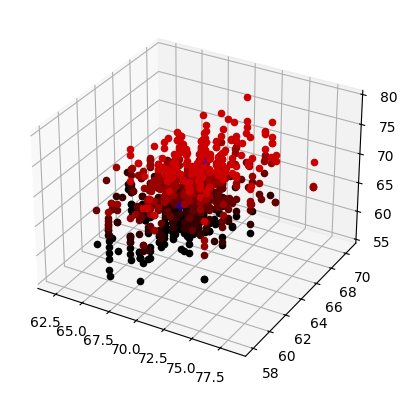

In [78]:
# We will cluster our data into approximated points with the following logic:

"""
Choose an arbitrary dimension, then go from intervals of desired length, look at all data points within interval, then generate averages for each cluster detected
"""
# TODO: Find which column to cluster by using the lowest loss function value

# First sort our data set given the row we choose to cluster by
chosen_column = 'childHeight'

# Sort the dataset by the chosen column
data_csv_sorted = data_csv.sort_values(by=chosen_column)
chunk_amount = 5 # amount of desired chunks
chunk_size = 20 # amount of desired points in each chunk



# Pseudocode below
"""
for chunk in chunks:
    cluster_list = makeClusters(chunk)
    aprox_vectors = []
    
    for cluster in cluster_list:
        aprox_vectors.append(cluster.mean)

return aprox_vectors
"""

# A chunk is defined as a group of data points with relatively close proximity
def generate_chunks(data):
    chunk_list = []
    chunk_size = len(data) // chunk_amount
    for i in range(chunk_amount):
        start_index = i * chunk_size
        end_index = start_index + chunk_size if i < chunk_amount - 1 else len(data)
        chunk_list.append(data[start_index:end_index])
    return chunk_list


# Function to determine the optimal number of clusters
def determine_optimal_cluster_count(data, max_clusters=10, sensitivity=0.95):
    if len(data) <= 1:
        return 1  # Can't cluster if there's only one point
    distortions = []
    for k in range(1, min(len(data), max_clusters) + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    # Heuristic: choose the number of clusters where the reduction in inertia decreases significantly
    k_opt = 1
    for i in range(1, len(distortions)):
        if distortions[i-1] - distortions[i] < sensitivity * (distortions[0] - distortions[-1]):
            k_opt = i
            break
    return k_opt

color_index = 0


ax = plt.figure().add_subplot(projection='3d')

# Function to generate cluster averages
def generate_cluster_averages(chunk, num_clusters):
    global color_index
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(chunk)
    cluster_centers = kmeans.cluster_centers_
    
    for (x, y, z) in zip(chunk['father'], chunk['mother'], chunk['childHeight']):
        ax.scatter(x, y, z, color=(color_index * (1 / chunk_amount), 0, 0))
    color_index += 1
    return cluster_centers.tolist()


# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(all_data_points_df['father'], all_data_points_df['mother'], all_data_points_df['childHeight'], c=all_labels, cmap='viridis', marker='o')



# Generate chunks
chunks = generate_chunks(data_csv_sorted)
# print(chunks[0])

# Initialize list to store cluster averages
cluster_averages = []

# Generate cluster averages for each chunk
for chunk in chunks:
    # print(chunk)
    cluster_averages.extend(generate_cluster_averages(chunk, determine_optimal_cluster_count(chunk)))

# Plotting the cluster averages
x_values = [avg[0] for avg in cluster_averages] 
y_values = [avg[1] for avg in cluster_averages]  # Assuming cluster averages are 1D, adjust if they are multidimensional
z_values = [avg[2] for avg in cluster_averages]

ax.scatter(x_values, y_values, z_values, color='blue')

print(cluster_averages)



[[68.33118279569892, 63.55537634408602, 61.851612903225806], [68.83010752688172, 63.78978494623656, 64.53118279569892], [69.21612903225807, 64.12096774193549, 66.5725806451613], [69.51397849462366, 64.05483870967743, 68.92956989247313], [70.07526315789474, 64.90789473684211, 71.73736842105264]]


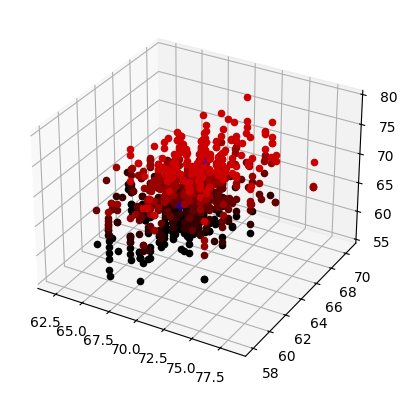

In [67]:
# We will cluster our data into approximated points with the following logic:

"""
Choose an arbitrary dimension, then go from intervals of desired length, look at all data points within interval, then generate averages for each cluster detected
"""
# TODO: Find which column to cluster by using the lowest loss function value

# First sort our data set given the row we choose to cluster by
chosen_column = 'childHeight'

# Sort the dataset by the chosen column
data_csv_sorted = data_csv.sort_values(by=chosen_column)
chunk_amount = 5 # amount of desired chunks
chunk_size = 20 # amount of desired points in each chunk



# Pseudocode below
"""
for chunk in chunks:
    cluster_list = makeClusters(chunk)
    aprox_vectors = []
    
    for cluster in cluster_list:
        aprox_vectors.append(cluster.mean)

return aprox_vectors
"""

# A chunk is defined as a group of data points with relatively close proximity
def generate_chunks(data):
    chunk_list = []
    chunk_size = len(data) // chunk_amount
    for i in range(chunk_amount):
        start_index = i * chunk_size
        end_index = start_index + chunk_size if i < chunk_amount - 1 else len(data)
        chunk_list.append(data[start_index:end_index])
    return chunk_list


# Function to determine the optimal number of clusters
def determine_optimal_cluster_count(data, max_clusters=10, sensitivity=0.95):
    if len(data) <= 1:
        return 1  # Can't cluster if there's only one point
    distortions = []
    for k in range(1, min(len(data), max_clusters) + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    # Heuristic: choose the number of clusters where the reduction in inertia decreases significantly
    k_opt = 1
    for i in range(1, len(distortions)):
        if distortions[i-1] - distortions[i] < sensitivity * (distortions[0] - distortions[-1]):
            k_opt = i
            break
    return k_opt

color_index = 0
ax = plt.figure().add_subplot(projection='3d')

# Function to generate cluster averages
def generate_cluster_averages(chunk, num_clusters):
    global color_index
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(chunk)
    cluster_centers = kmeans.cluster_centers_
    
    for (x, y, z) in zip(chunk['father'], chunk['mother'], chunk['childHeight']):
        ax.scatter(x, y, z, color=(color_index * (1 / chunk_amount), 0, 0))
    color_index += 1
    return cluster_centers.tolist()


# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(all_data_points_df['father'], all_data_points_df['mother'], all_data_points_df['childHeight'], c=all_labels, cmap='viridis', marker='o')



# Generate chunks
chunks = generate_chunks(data_csv_sorted)
# print(chunks[0])

# Initialize list to store cluster averages
cluster_averages = []

# Generate cluster averages for each chunk
for chunk in chunks:
    # print(chunk)
    cluster_averages.extend(generate_cluster_averages(chunk, determine_optimal_cluster_count(chunk)))

# Plotting the cluster averages
x_values = [avg[0] for avg in cluster_averages] 
y_values = [avg[1] for avg in cluster_averages]  # Assuming cluster averages are 1D, adjust if they are multidimensional
z_values = [avg[2] for avg in cluster_averages]

ax.scatter(x_values, y_values, z_values, color='blue')

print(cluster_averages)



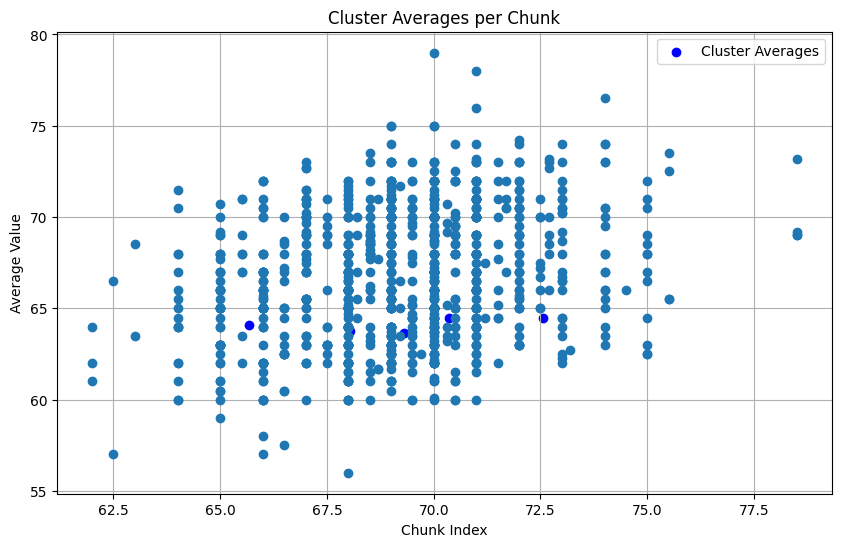

In [44]:
# Plotting the cluster averages
x_values = [avg[0] for avg in cluster_averages] 
y_values = [avg[1] for avg in cluster_averages]  # Assuming cluster averages are 1D, adjust if they are multidimensional

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, c='blue', marker='o', label='Cluster Averages')
plt.xlabel('Chunk Index')
plt.ylabel('Average Value')
plt.title('Cluster Averages per Chunk')
plt.plot(data_csv["father"], data_csv["childHeight"], 'o')
plt.legend()
plt.grid(True)
plt.show()

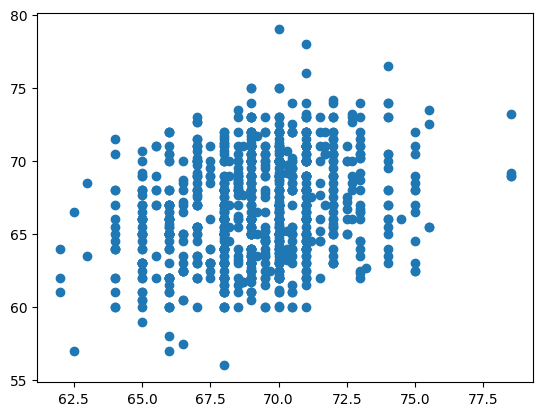

In [45]:
# Lets compare how the estimated cluster averages compare to the actual data
plt.plot(data_csv["father"], data_csv["childHeight"], 'o')

# Connecting approximation points

In [46]:
# Connect each cluster with another node that has the best (density - distance) value, lets define the functions below...

density_bias = 1
distance_bias = 1

def density_value(p1, p2):
    # calculated via
    # (# of data in area between two points) / (size of the area) * density_bias
    pass

def distance_value(p1, p2):
    # calculated via
    # point distance * distance_bias
    pass